In [41]:
from functions import *
import numpy as np
from qiskit.algorithms.optimizers import SPSA,GradientDescent,COBYLA,ADAM
from qiskit.quantum_info import Statevector,state_fidelity
from qiskit.visualization import plot_bloch_multivector
from qiskit import Aer

In [42]:



# These specify the measurement directions and outcomes (each direction has two eigenstates)
x0=Statevector([1/np.sqrt(2),1/np.sqrt(2)])
x1=Statevector([1/np.sqrt(2),-1/np.sqrt(2)])
z0=Statevector([1,0])
z1=Statevector([0,1])

measurement_list=[z0,z1,x0,x1]



In [43]:
# Form the projectors (measurement operators corresponding to those directions and outcomes ) : 4 operators for 4 outcomes
op_list=get_operator_list(measurement_list)
op_list

array([[[ 0.5 +0.j,  0.  +0.j],
        [ 0.  +0.j,  0.  +0.j]],

       [[ 0.  +0.j,  0.  +0.j],
        [ 0.  +0.j,  0.5 +0.j]],

       [[ 0.25+0.j,  0.25+0.j],
        [ 0.25+0.j,  0.25+0.j]],

       [[ 0.25+0.j, -0.25+0.j],
        [-0.25+0.j,  0.25-0.j]]])

In [44]:




class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept=None):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

def new_objective_function(parameters):
    '''
    This objective function uses a different parameterisation for the quantum state.
    It takes in 3 complex parameters
    '''
    t1=parameters[0]
    t2=parameters[1]
    t3=parameters[2]
    T=np.array([[0,t1],[t2,t3]],dtype=np.complex128)
    T_=np.transpose(np.conj(T))
    
    rho=np.matmul(T,T_)   # a state on a bloch sphere at some (x,y=0,z) has this matrix representation
    tr=np.trace(rho)
    rho=rho/tr
    
    loss=0
    for i,value in enumerate(frequency_data):
       
        
        
        operator=op_list[i]
        
        predicted_prob= np.trace(np.matmul(rho,operator))    # Rule to calculate probabilities from a given state rho and measurement operator
        
        
        loss=loss-value*np.log(np.abs(predicted_prob))     #loss function as defined in the reference shared on MLE, this is called the log likelihood
        
    
    #loss=loss+1000*(np.linalg.norm(parameters) - 1)**2       #add for constraint that the state lies on the bloch sphere
    return loss

def params_to_rho(opt_var):

    t1=opt_var[0]
    t2=opt_var[1]
    t3=opt_var[2]
    T=np.array([[0,t1],[t2,t3]],dtype=np.complex128)
    T_=np.transpose(np.conj(T))
    
    rho=np.matmul(T,T_)   # a state on a bloch sphere at some (x,y=0,z) has this matrix representation
    tr=np.trace(rho)
    rho=rho/tr
    
    return rho

#
##  We fix any target state by hand and give the frequencies corresponding to that state as the input to the algorithm. The measured frequencies are obtained by an IBM backend from get_frequencies function 


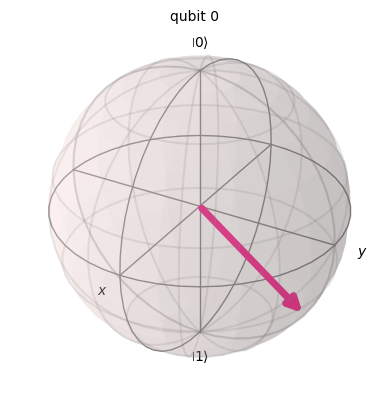

In [45]:
    
measurement_directions=[(0,0),(np.pi/2,0),(np.pi/2,np.pi/2)]

target_state=np.array([1/np.sqrt(5),1.0j*np.sqrt(1-1/5)])

#frequency_data=[0.25,0.25,0.5,0.0]                      # Pass frequency data as a list rather than a dictionary in new version

frequency_data=get_frequencies(measurement_directions,Aer.get_backend('qasm_simulator'),initial_state=target_state)

op_list=get_operator_list(spherical_to_amplitudes(measurement_directions))

plot_bloch_multivector(target_state)


In [46]:
# Set and optimizer
GD_log=OptimizerLog()

#optimizer_SPSA = SPSA(maxiter=200, callback=SPSA_log.update)

optimizer_GD=GradientDescent(maxiter=300,callback=GD_log.update,perturbation=0.1,learning_rate=0.4)

In [47]:
initial_point = np.random.uniform(-1, 1, size=3) + np.random.uniform(-1, 1, size=3) * 1j


result_GD=optimizer_GD.minimize(new_objective_function,initial_point)
print(initial_point)

[ 0.77861443-0.71862011j -0.27094767+0.58109209j  0.7829708 +0.60770178j]


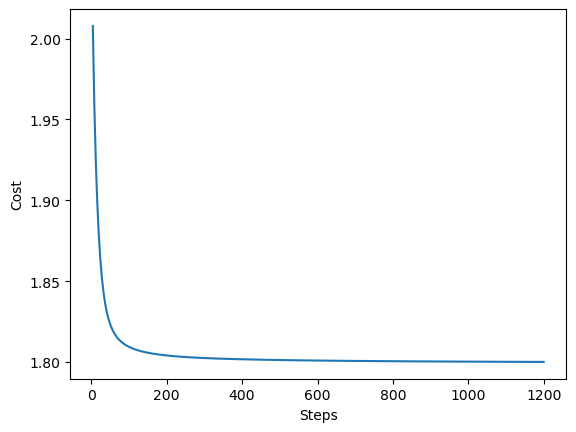

1.800114006516507
final parameters :  [-0.42450346-0.71862011j -0.64471238+0.58109209j  2.68406045+0.60770178j]
1200


In [48]:
opt_var = result_GD.x
opt_value = result_GD.fun
y=result_GD.nfev

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(GD_log.evaluations, GD_log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()
print(opt_value)
print('final parameters : ' ,opt_var)
print(y)

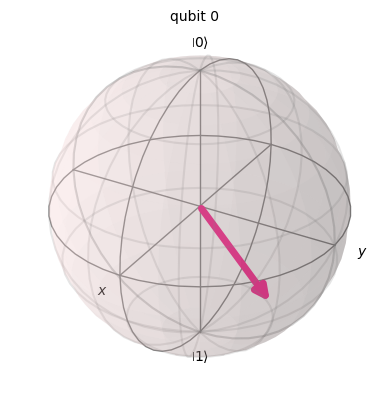

In [49]:
rho=params_to_rho(opt_var)

plot_bloch_multivector(rho)

In [50]:
fidelity=state_fidelity(target_state,rho)
print('state_fidelity : ',  fidelity )

state_fidelity :  0.9018136816566429
